<a href="https://colab.research.google.com/github/YazdanGolzade/GNN-Tutorial-with-PyTorch_geometric/blob/main/01_GNN_Tutorial_2021_13_September.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INTRODUCTION BY EXAMPLE**

We shortly introduce the fundamental concepts of PyG through self-contained examples. 

At its core, PyG provides the following main features:

--Data Handling of Graphs

--Common Benchmark Datasets

--Mini-batches

--Data Transforms

--Learning Methods on Graphs(**GCN**)

**Install the relevant packages:**

In [ ]:
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-geometric

**Data Handling of Graphs**

We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:

In [2]:
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [4]:
#Visualize of graph
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import pylab as plb
import matplotlib.pyplot as plt

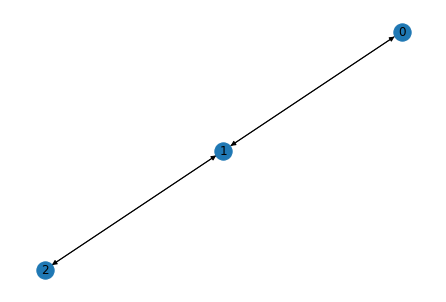

In [5]:
nx_graph = to_networkx(data)
nx.draw(nx_graph, with_labels = True)
plb.savefig('labels.png')

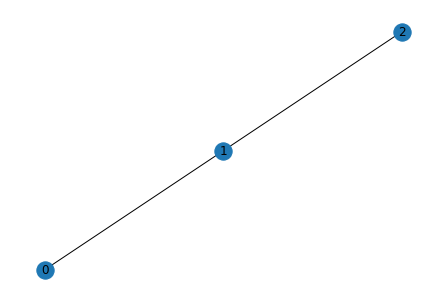

In [6]:
#convert directed graph to undirected

nx_undirected_graph = nx_graph.to_undirected()

nx.draw(nx_undirected_graph, with_labels = True)
plt.savefig('labels.png')

In [7]:
print(data.keys)

['x', 'edge_index']


In [8]:
print(data['x'])

tensor([[-1.],
        [ 0.],
        [ 1.]])


In [9]:
for key, item in data:
    print("{} found in data".format(key))

x found in data
edge_index found in data


In [10]:
'edge_attr' in data

False

In [11]:
data.num_nodes

3

In [12]:
data.num_edges

4

In [13]:
data.num_node_features

1

In [14]:
#data.has_isolated_nodes()

In [ ]:
#data.has_self_loops()

In [ ]:
#data.is_directed()

**Common Benchmark Datasets**

Initializing a dataset is straightforward. 

An initialization of a dataset will automatically download its raw files and process them to the previously described Data format. E.g., to load the ENZYMES dataset (consisting of 600 graphs within 6 classes), type:

In [17]:
from torch_geometric.datasets import TUDataset

ENZYMES = TUDataset(root='/tmp/ENZYMES', name='ENZYMES',use_node_attr=True)

In [18]:
len(ENZYMES)

600

In [19]:
ENZYMES.num_classes

6

In [20]:
ENZYMES.num_node_features

21

We now have access to all 600 graphs in the dataset:

In [21]:
ENZYMES_0 = ENZYMES[0]

In [22]:
ENZYMES_0 .is_undirected()

True

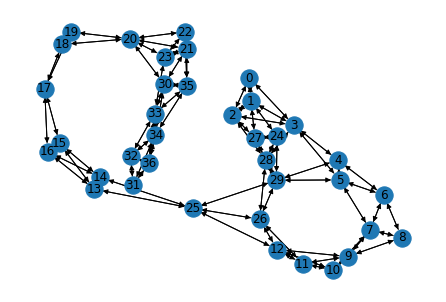

In [23]:
nx_graph = to_networkx(ENZYMES_0 )
nx.draw(nx_graph, with_labels = True)
plb.savefig('labels.png')

We can see that the first graph in the dataset contains 37 nodes, each one having 3 features. There are 168/2 = 84 undirected edges and the graph is assigned to exactly one class. In addition, the data object is holding exactly one graph-level target.

**train/test split**

We can even use slices, long or bool tensors to split the dataset. E.g., to create a 90/10 train/test split, type:

In [24]:
train_ENZYMES = ENZYMES[:540]
test_ENZYMES = ENZYMES[540:]

If you are unsure whether the dataset is already shuffled before you split, you can randomly permutate it by running:

In [ ]:
ENZYMES = ENZYMES.shuffle()

**Mini-batches**

Neural networks are usually trained in a batch-wise fashion. PyG achieves parallelization over a mini-batch by creating sparse block diagonal adjacency matrices (defined by edge_index) and concatenating feature and target matrices in the node dimension. This composition allows differing number of nodes and edges over examples in one batch:

PyG contains its own torch_geometric.loader.DataLoader, which already takes care of this concatenation process.

 Let’s learn about it in an example:

In [25]:
from torch_scatter import scatter_mean
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid

In [26]:
ENZYMES = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
ENZYMES_loader = DataLoader(ENZYMES, batch_size=32, shuffle=True)


In [28]:
for batch_ENZYMES in ENZYMES_loader:
 batch_ENZYMES
    
batch_ENZYMES.num_graphs

24

**Data Transforms**

Transforms are a common way in torchvision to transform images and perform augmentation.

 PyG comes with its own transforms, which expect a Data object as input and return a new transformed Data object. 
 
 Transforms can be chained together using torch_geometric.transforms.Compose and are applied before saving a processed dataset on disk (pre_transform) or before accessing a graph in a dataset (transform).

Let’s look at an example, where we apply **transforms** on the **ShapeNet dataset** (containing 17,000 3D shape point clouds and per point labels from 16 shape categories).

In [29]:
from torch_geometric.datasets import ShapeNet

Airplane = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'])

Airplane[0]

Processing...
Done!


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])

We can **convert** the point cloud dataset into a **graph dataset** by generating nearest neighbor graphs from the point clouds via transforms:

In [31]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

Airplane = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'],
                    pre_transform=T.KNNGraph(k=6))

Airplane[0]

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/dataset.py:152: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to sure to delete '/tmp/ShapeNet/processed' first
  f"The `pre_transform` argument differs from the one used in "


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])

**Learning Methods on Graphs: implement our first graph neural network!**

After learning about data handling, datasets, loader and transforms in PyG, it’s time to implement our first graph neural network!

We will use a simple GCN layer and replicate the experiments on the Cora citation dataset.

 For a high-level explanation on **GCN**, have a look at its blog post.

We first need to load the **Cora dataset**:

In [33]:
from torch_geometric.datasets import Planetoid

Cora = Planetoid(root='/tmp/Cora', name='Cora')

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [34]:
Cora.num_node_features

1433

In [35]:
 Cora.num_classes

7

Note that we do not need to use transforms or a dataloader. Now let’s implement a two-layer GCN:

In [36]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv( Cora.num_node_features, 16)
        self.conv2 = GCNConv(16,  Cora.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

The constructor defines two GCNConv layers which get called in the forward pass of our network. Note that the non-linearity is not integrated in the conv calls and hence needs to be applied afterwards (something which is consistent accross all operators in PyG). Here, we chose to use ReLU as our intermediate non-linearity and finally output a softmax distribution over the number of classes. Let’s train this model on the training nodes for 200 epochs:

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data =  Cora[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

Finally, we can evaluate our model on the test nodes:

In [39]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8050


This is all it takes to implement your first graph neural network. The easiest way to learn more about Graph Neural Networks is to study the examples in the examples/ directory and to browse torch_geometric.nn. Happy hacking!